In [29]:
## Show the total number of observations per species
## Which species has less observations?
## Which species has more observations?
## Understand how the number of observations is correlated with the status
## What is the category more endangered?

import pandas as pd

obs = pd.read_csv('observations.csv')
species = pd.read_csv('species_info.csv')

print(obs.head())
print(species.head())

print(obs.count())
print(species.count())

print(species[species['scientific_name'] == 'Canis lupus'])

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic 

In [2]:
## Show the total number of observations per species

obs_grouped = obs.groupby('scientific_name', as_index=False)['observations'].sum()
obs_grouped_sorted = obs_grouped.sort_values('observations', ascending=False)

print(obs_grouped_sorted.head())


            scientific_name  observations
4993  Streptopelia decaocto          1785
2452         Holcus lanatus          1780
1103      Castor canadensis          1725
2555   Hypochaeris radicata          1720
4179          Puma concolor          1711


In [3]:
## Which species has less observations?

less_viewed_species = obs_grouped_sorted['scientific_name'].iloc[-1]
less_views = obs_grouped_sorted['observations'].iloc[-1]
print('The species with less observations is ' + less_viewed_species + ' with ' + str(less_views) + ' views.')

The species with less observations is Grus americana with 131 views.


In [4]:
## Which species has more observations?

most_viewed_species = obs_grouped_sorted['scientific_name'].iloc[0]
most_views = obs_grouped_sorted['observations'].iloc[0]
print('The species with less observations is ' + most_viewed_species + ' with ' + str(most_views) + ' views.')

The species with less observations is Streptopelia decaocto with 1785 views.


['Unknown' 'Species of Concern' 'Threatened' 'In Recovery' 'Endangered']


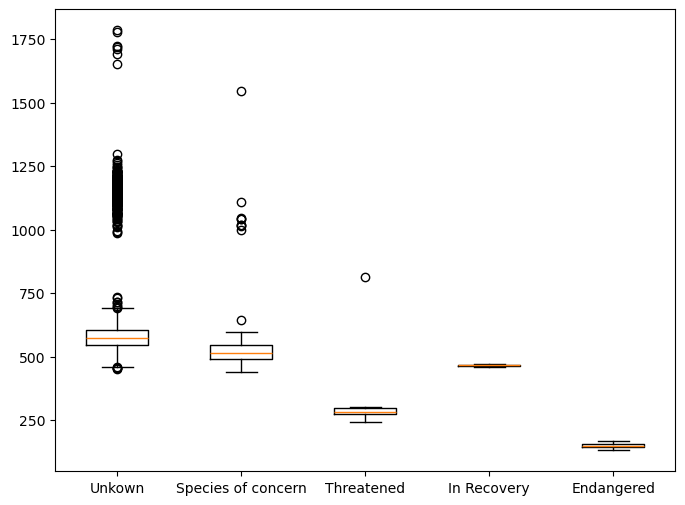

                     min   max        mean
conservation_status                       
Endangered           131   166  148.785714
In Recovery          457   470  464.000000
Species of Concern   441  1547  546.880795
Threatened           242   813  333.900000
Unknown              451  1785  601.407048


In [85]:
## Fill the missing conservation status of the species
import numpy as np
import matplotlib.pyplot as plt

#merge the dataframes
merged_df = pd.merge(obs_grouped_sorted, species, on='scientific_name', how='left')

## group the df and join as csv the commom names and conservation status
merged_df = merged_df.groupby(['scientific_name', 'category', 'observations'], as_index=False).agg({'common_names': ','.join, 'conservation_status': lambda x: ','.join(x.dropna())})

## there are 'Or' on common names that should be replaced by commas
merged_df['common_names'] = merged_df['common_names'].str.replace(' Or ', ', ', regex=True)

## sorte values by observations
merged_df = merged_df.sort_values('observations', ascending=False).reset_index(drop=True)

## remove spaces in the beggining or end
merged_df['conservation_status'] = merged_df['conservation_status'].str.strip()
merged_df['common_names'] = merged_df['common_names'].str.strip()

## remove duplicates in the csv columns
def remove_duplicates(csv_string):
    # Split the CSV string into a list, convert to a set (removes duplicates), and join back to a string
    return ','.join(sorted(set(csv_string.split(','))))

merged_df['conservation_status'] = merged_df['conservation_status'].apply(remove_duplicates)
merged_df['common_names'] = merged_df['common_names'].apply(remove_duplicates)

## replace '' for NaN values
merged_df.replace('', 'Unknown', inplace=True)

## there is one record that has 2 different conservation status (Endengered and In Recovery) -> to set this as null 
merged_df.loc[merged_df['conservation_status'].str.contains(',', na=False), 'conservation_status'] = 'Unknown'

## check unique values
unique_status = merged_df['conservation_status'].unique()
print(unique_status)

## show a box plot per conservation status
plt.figure(figsize=(8,6))
plt.boxplot([merged_df[merged_df['conservation_status'] == category]['observations'] for category in unique_status])
plt.xticks([1, 2, 3, 4, 5], ['Unkown', 'Species of concern', 'Threatened', 'In Recovery', 'Endangered'])  # Set custom labels for x-axis
plt.show()

## group by conservation status and get the min, max and mean observations for each status
status_gb = merged_df.groupby('conservation_status')['observations'].agg(['min', 'max', 'mean'])

print(status_gb)



category             Amphibian  Bird  Fish  Mammal  Nonvascular Plant  \
conservation_status                                                     
Species of Concern           4    68     4      22                  5   
In Recovery                  0     3     0       0                  0   
Threatened                   2     0     4       2                  0   
Endangered                   1     4     3       5                  0   

category             Reptile  Vascular Plant  
conservation_status                           
Species of Concern         5              43  
In Recovery                0               0  
Threatened                 0               2  
Endangered                 0               1  


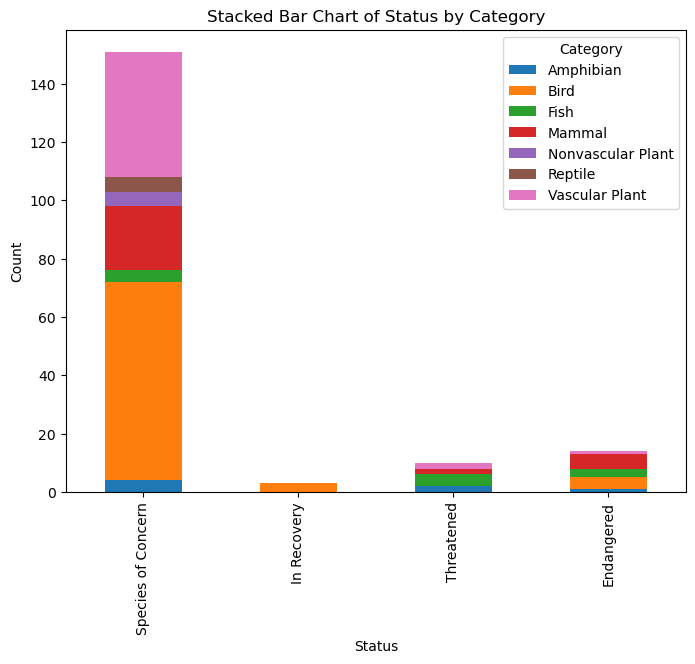

In [107]:
## What is the category more endangerous?

result = pd.crosstab(merged_df['conservation_status'], merged_df['category'])

# Remove a specific status (e.g., "Unknown")
result = result.drop(index='Unknown', errors='ignore')
custom_order = ['Species of Concern', 'In Recovery', 'Threatened', 'Endangered']
result = result.reindex(custom_order)

print(result)

result.plot(kind='bar', stacked=True, figsize=(8,6))

# Labels and title
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Status by Category')
plt.legend(title='Category')

# Show the plot
plt.show()